# Micrograd

This notebook follows karpathy's video [here](https://www.youtube.com/watch?v=VMj-3S1tku0).

In [249]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
def f(x):
    return 3*x**2 - 4*x + 5

In [251]:
f(3.0)

20.0

In [252]:
xs = np.arange(-5, 5, .25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

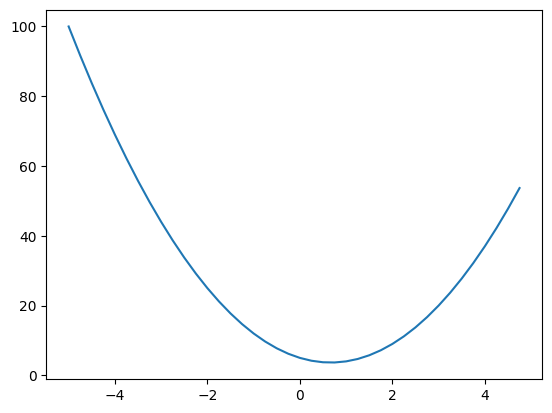

In [253]:
ys = f(xs)
plt.plot(xs, ys)

In [254]:
h = .001
x = 3.0
(f(x + h) - f(x)) / h # numerical approx of the slope

14.00300000000243

In [255]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

The following computes the slope. The result is b.

In [256]:
h = .00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [257]:
h = .00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


Let's automate this process as neural networks are very complex.

In [258]:
class Value:

    # When creating a Value from an operation,
    # populate the set.
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [259]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "Loss"

print(d._prev, d._op)

{Value(data=-6.0), Value(data=10.0)} +


Visualize complex graphs.

In [260]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "%s | data %.4f" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

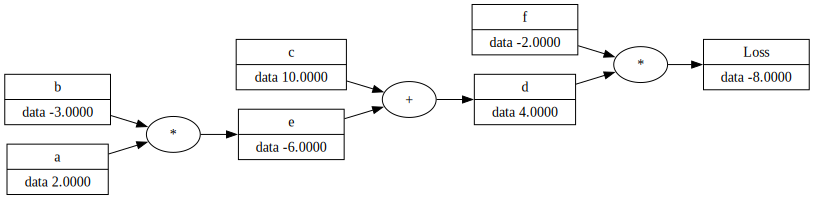

In [261]:
draw_dot(L)

Let's apply backpropagation. For every single value, we are going to compute the derivative w.r.t. the Loss.

In [262]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

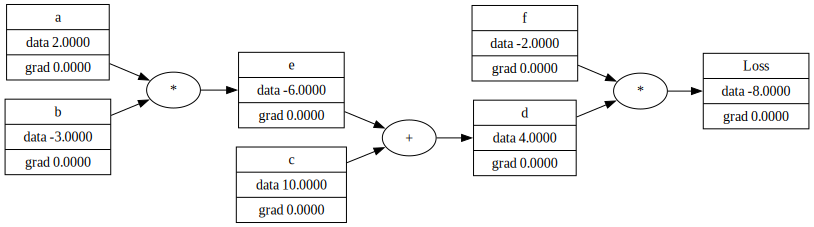

In [263]:
def scope():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"

    return draw_dot(L)

scope()

What is the derivative of L w.r.t. L? Answer is 1. The change will be proportional.

In [264]:
L.grad = 1.0

$
L = d * f
$

$
DL/dd =? f
$

We can apply the formula:
$(f(x + h) - f(x)) / h$

$dL/dd = ((d + h) * f - d * f) / h = f * h / h = f = -2.0$

Similarly, $dL/df = d = 4.0$

Let's check $DL/dd$ numerically using a small step size

In [265]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    d.data += h # nudging the input
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

-1.9999999999242843


$
d = c + e
$

$
dd/dc =? 1
$

$
(c + h + e - (c + e)) / h = 1
$

Now that we understood the gradient for individual nodes, let's apply the linear rule.

Want: $DL/dc$

Know: $DL/dd$, $dd/dc$

$
DL/dc = DL/dd * dd/dc = -2.0 * 1.0 = -2.0
$

Observation: the + node just routes the gradient

In [266]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0 + h, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

-1.9999999999242843


What about $dL/da$? Applying the chain rule, $dL/da = dL/dd * dd/de * de/da$

Know: $dd/de = 1$

$e = a * b$
$de/da =? b$

Again we can apply the formula just to check

$
((a + h) * b - a * b) / h = b
$

So we get $dL/da = -2.0 * -3.0 = 6.0$

Similarly, $dL/db = -2.0 * 2.0 = -4.0$

In [267]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

6.000000000128124


Let's simulate a single optimization step. We plug all gradients calculated above manually.

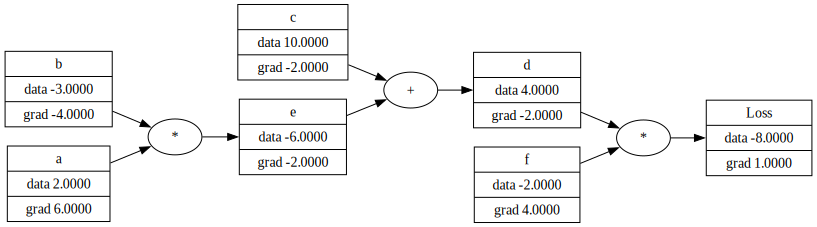

In [270]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"

    L.grad = 1.0
    f.grad = 4.0
    e.grad = -2.0
    d.grad = -2.0
    c.grad = -2.0
    b.grad = -4.0
    a.grad = 6.0

    return draw_dot(L)

lol()

If we go in the direction of the gradient, we will increase $L$

In [279]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    print(L)

    L.grad = 1.0
    f.grad = 4.0
    e.grad = -2.0
    d.grad = -2.0
    c.grad = -2.0
    b.grad = -4.0
    a.grad = 6.0

    # We have control on the leaf nodes
    rate = 0.01
    a.data += rate * a.grad
    b.data += rate * b.grad
    c.data += rate * c.grad
    f.data += rate * f.grad

    # Forward pass
    e = a * b
    d = c + e
    L = d * f
    print(L)

lol()

Value(data=-8.0)
Value(data=-7.286496)
